## Overview
1. Import only training datasets since kaggle's sorcing system does not function correctly
2. Split training data sets into two parts: training & testing sets
3. Feature engineering
    * Since each sample covers 10 sensor channels and 128 measurements per time series, we need to group these measurements into one sample
    * Measurements are extracted by grouping the series on functions: max, min, median, mean, std, absolute maximum and quantiles
4. Use Random Forest Classifier (from scikit-learn) to train the model
5. Check model accuracy
    * OOB score
    * 10-Fold cross validation
    * 20 samples testing data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

## Read in Kaggle datasets

In [2]:
X_train = pd.read_csv('./Data/career-con-2019/X_train.csv')
y_train = pd.read_csv('./Data/career-con-2019/y_train.csv')

Let's see what the training set looks like  
It has 487680 samples, each has 13 features (not all of them are usable and will be dropped later)

In [3]:
X_train.ndim, X_train.shape

(2, (487680, 13))

Now let's split training sets into two parts
* Last 20 groups will be used as testing set
* Rest will be used as traning set

In [4]:
# split X_train
samples = 20
time_series = 128
start_x = X_train.shape[0] - samples*time_series
X_train, X_test = X_train.iloc[:start_x], X_train.iloc[start_x:]
# split y_train
start_y = y_train.shape[0] - samples
y_train, y_test = y_train.iloc[:start_y], y_train.iloc[start_y:]

Before we go on to modify the data, first check out the information of the set  
This can give us some insight of the data

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485120 entries, 0 to 485119
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 485120 non-null  object 
 1   series_id              485120 non-null  int64  
 2   measurement_number     485120 non-null  int64  
 3   orientation_X          485120 non-null  float64
 4   orientation_Y          485120 non-null  float64
 5   orientation_Z          485120 non-null  float64
 6   orientation_W          485120 non-null  float64
 7   angular_velocity_X     485120 non-null  float64
 8   angular_velocity_Y     485120 non-null  float64
 9   angular_velocity_Z     485120 non-null  float64
 10  linear_acceleration_X  485120 non-null  float64
 11  linear_acceleration_Y  485120 non-null  float64
 12  linear_acceleration_Z  485120 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.1+ MB


Also let's see how many series each type has

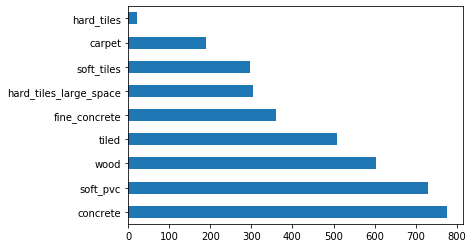

In [6]:
y_train['surface'].value_counts().plot(kind='barh')

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((485120, 13), (3790, 3), (2560, 13), (20, 3))

In [8]:
X_train.head(1)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.10765,0.017561,0.000767,-0.74857,2.103,-9.7532


In [9]:
X_train.keys()

Index(['row_id', 'series_id', 'measurement_number', 'orientation_X',
       'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z'],
      dtype='object')

In [10]:
y_train.keys()

Index(['series_id', 'group_id', 'surface'], dtype='object')

## Process datasets
The first thing we want to do is to drop those useless columns (features)

In [11]:
X_train = X_train.drop(['row_id', 'measurement_number'], axis=1)
X_test = X_test.drop(['row_id', 'measurement_number'], axis=1)
y_train = y_train.drop('group_id', axis=1)
y_test = y_test.drop('group_id', axis=1)

In [12]:
X_train.head(1)

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.10765,0.017561,0.000767,-0.74857,2.103,-9.7532


In [13]:
X_test.head(1)

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
485120,3790,0.70992,0.68801,0.10876,0.10405,-0.87528,0.13835,0.037472,-2.455,-0.89309,-20.604


In [14]:
y_train.head(1)

,series_id,surface
0,0,fine_concrete


In [15]:
y_test.head(1)

,series_id,surface
3790,3790,hard_tiles_large_space


We have 128 measurements for each series, it is hard to train  
So we want to compress these 128 measurements into a single measurement  
First, we will add 3 more features to each measurement, which will be the sum of orientation, angular_velocity, and linear_acceleration

In [16]:
columns = ['orientation', 'angular_velocity', 'linear_acceleration']
for i in columns:
    if(i == 'orientation'):
        X_train[i] = X_train[i+'_X'] + X_train[i+'_Y'] + X_train[i+'_Z'] + X_train[i+'_W']
        X_test[i] = X_test[i+'_X'] + X_test[i+'_Y'] + X_test[i+'_Z'] + X_test[i+'_W']
    else:
        X_train[i] = X_train[i+'_X'] + X_train[i+'_Y'] + X_train[i+'_Z']
        X_test[i] = X_test[i+'_X'] + X_test[i+'_Y'] + X_test[i+'_Z']

In [17]:
X_train.head(1)

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,orientation,angular_velocity,linear_acceleration
0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.10765,0.017561,0.000767,-0.74857,2.103,-9.7532,-1.60373,0.125978,-8.39877


In [18]:
X_test.head(1)

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,orientation,angular_velocity,linear_acceleration
485120,3790,0.70992,0.68801,0.10876,0.10405,-0.87528,0.13835,0.037472,-2.455,-0.89309,-20.604,1.61074,-0.699458,-23.95209


Next, we want to calculate *max, min, mean, median, abs_max, std, quartile(25%), quartile(50%), quartile(75%)* for each series (128 measurements) to maintain as much information as possiable  
* Every sample has 13 features before, each of the features will become 9 values after compression, so there will be 9 * 13 features for each sample after calculation
* There was 485120 measurements before compression, and will become 485120 / 128 = 3790 samples after calsulation

In [19]:
%%time

T_train = pd.DataFrame()
T_test = pd.DataFrame()

for i in X_train.columns[1:]:
    T_train[i+'_max'] = X_train.groupby(by='series_id')[i].max()
    T_test[i+'_max'] = X_test.groupby(by='series_id')[i].max()

    T_train[i+'_min'] = X_train.groupby(by='series_id')[i].min()
    T_test[i+'_min'] = X_test.groupby(by='series_id')[i].min()

    T_train[i+'_mean'] = X_train.groupby(by='series_id')[i].mean()
    T_test[i+'_mean'] = X_test.groupby(by='series_id')[i].mean()

    T_train[i+'_median'] = X_train.groupby(by='series_id')[i].median()
    T_test[i+'_median'] = X_test.groupby(by='series_id')[i].median()

    T_train[i+'_quantile_25'] = X_train.groupby(by='series_id')[i].quantile(0.25)
    T_test[i+'_quantile_25'] = X_test.groupby(by='series_id')[i].quantile(0.25)

    T_train[i+'_quantile_50'] = X_train.groupby(by='series_id')[i].quantile(0.5)
    T_test[i+'_quantile_50'] = X_test.groupby(by='series_id')[i].quantile(0.5)

    T_train[i+'_quantile_75'] = X_train.groupby(by='series_id')[i].quantile(0.75)
    T_test[i+'_quantile_75'] = X_test.groupby(by='series_id')[i].quantile(0.75)

    T_train[i+'_abs_max'] = X_train.groupby(by='series_id')[i].apply(lambda x: np.max(np.abs(x)))
    T_test[i+'_abs_max'] = X_test.groupby(by='series_id')[i].apply(lambda x: np.max(np.abs(x)))

    T_train[i+'_std'] = X_train.groupby(by='series_id')[i].std()
    T_test[i+'_std'] = X_test.groupby(by='series_id')[i].std()
    
X_train = T_train
X_test = T_test

CPU times: user 19.2 s, sys: 415 ms, total: 19.6 s
Wall time: 19.6 s


In [20]:
X_train.head(1)

,orientation_X_max,orientation_X_min,orientation_X_mean,orientation_X_median,orientation_X_quantile_25,orientation_X_quantile_50,orientation_X_quantile_75,orientation_X_abs_max,orientation_X_std,orientation_Y_max,...,angular_velocity_std,linear_acceleration_max,linear_acceleration_min,linear_acceleration_mean,linear_acceleration_median,linear_acceleration_quantile_25,linear_acceleration_quantile_50,linear_acceleration_quantile_75,linear_acceleration_abs_max,linear_acceleration_std
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.75822,-0.75953,-0.758666,-0.75853,-0.758927,-0.75853,-0.758367,0.75953,0.000363,-0.63306,...,0.054317,-1.2896,-12.3536,-6.072777,-5.908943,-7.654925,-5.908943,-4.575425,12.3536,2.435261


In [21]:
X_train.shape

(3790, 117)

In [22]:
X_test.head(1)

,orientation_X_max,orientation_X_min,orientation_X_mean,orientation_X_median,orientation_X_quantile_25,orientation_X_quantile_50,orientation_X_quantile_75,orientation_X_abs_max,orientation_X_std,orientation_Y_max,...,angular_velocity_std,linear_acceleration_max,linear_acceleration_min,linear_acceleration_mean,linear_acceleration_median,linear_acceleration_quantile_25,linear_acceleration_quantile_50,linear_acceleration_quantile_75,linear_acceleration_abs_max,linear_acceleration_std
series_id,,,,,,,,,,,,,,,,,,,,,
3790,0.71142,0.70935,0.710416,0.710435,0.70993,0.710435,0.710742,0.71142,0.000525,0.68865,...,0.404159,36.1585,-40.3143,-6.246652,-6.895725,-13.283697,-6.895725,1.886032,40.3143,13.149371


In [23]:
X_test.shape

(20, 117)

## Train and test model
For this project, I am using Random Forest Classifier from scikit-learn to train the model  
Since this project is a classify problem, it is very suitable for using ensemble learning  
* we'll set 300 estimators (after trying many times, I find this number will get the nearly best result and won't cost too much time)
* Set a random seed (I set it to the course number of AI hhh)
* The default bootstrap parameter is set to True, it means that we are using bagging. But since there're almost 30% of the samples will not be chosen in the training model, we will set oob_score to True, so that we can use those not chosen smaples to test the accuracy of our model
* Set n_jobs to -1, we want to use every single CPU to train our model so that it won't take too long

In [24]:
%%time

rf_clf = RandomForestClassifier(n_estimators=300,
                                random_state=6613,
                                oob_score=True,
                                n_jobs=-1)
rf_clf.fit(X_train, y_train['surface'])

CPU times: user 12.7 s, sys: 210 ms, total: 12.9 s
Wall time: 2.53 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=6613, verbose=0,
                       warm_start=False)

After training the model, let's see the accuracy of our model, and we are using:  
* Out-of-bag score
* 10-Fold cross validation
* Testing set split from training set

We can see that this model can get about 89.6% accuracy

In [25]:
rf_clf.oob_score_

0.8968337730870712

In [26]:
%%time
scores = cross_val_score(rf_clf, X_train, y_train['surface'], cv = 10)
print('Accuracy: {:.2f} (+/- {:.2f})'.format(scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.05)
CPU times: user 9.84 s, sys: 1.48 s, total: 11.3 s
Wall time: 26.5 s


In [27]:
rf_clf.score(X_test, y_test['surface'])

0.85